In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

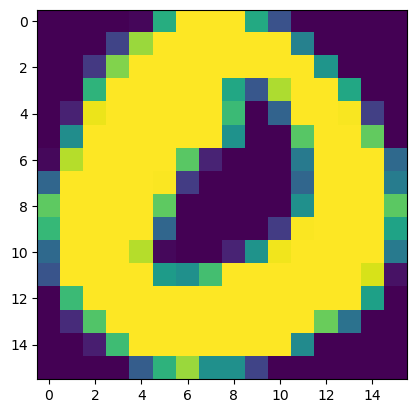

In [38]:
test_in = pd.read_csv("test_in.csv",index_col=None)
test_in.shape
im = test_in.iloc[0].values.reshape((16,16))
plt.imshow(im)

In [44]:
def no_index_read():
    def func(input:str):
        return pd.read_csv(input,index_col=None)
    return func
read_csv = no_index_read()

In [45]:
test_in = read_csv("test_in.csv")
test_out = read_csv("test_out.csv")
train_in = read_csv("train_in.csv")
train_out = read_csv("train_out.csv")